In [39]:
import torch
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import numpy as np

In [40]:
from config import args, device
def custom_config(args):
    args.img_size = 180
    args.dim_first = 3
    args.dim_second = 5
    args.dim_third = 8
    args.batch_size = 8
    args.margin_loss = 4.0
    args.border  = 21
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

args = custom_config(args)

In [41]:
def criar_mascara(dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((args.batch_size,1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

In [42]:
class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    - Sorts the rows of a matrix based on the last element of each row.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0,1,3,2,4]]# trocando x e y de ordem antes de concatenar

        return max_coords_values, max_map.squeeze().numpy()
    
    def sort_tensor_by_columns(self,tensor):
        # Ordena pela última coluna
        sorted_indices = torch.argsort(tensor[:, -1],descending=True)
        tensor_sorted_by_last_column = tensor[sorted_indices]
        return tensor_sorted_by_last_column
    
    def filter_coordinates(self, tensor, image_index, channel_index):
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords


def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

In [43]:
r2_act = gspaces.Rot2dOnR2(N=args.group_size)#N=8 is the number of Groups equivariant
OUT_SHAPE = 128
#This model is base to build the model for singular points detection e orientation estimation
class BaseFeatures(nn.Module):
    #This model extract 8 features from the image
    def __init__(self, args) -> None:
        super().__init__()
        self.pyramid_levels = args.pyramid_levels
        self.scale = args.scale_pyramid
        self.feat_type_in = enn.FieldType(r2_act, args.num_channels * [
            r2_act.trivial_repr])  ## input 1 channels (gray scale image)

        feat_type_out1 = enn.FieldType(r2_act, args.dim_first * [r2_act.regular_repr])
        feat_type_out2 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out3 = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
            enn.R2Conv(self.feat_type_in, feat_type_out1, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out1),
            enn.ReLU(feat_type_out1, inplace=True),
        )
        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_out1, feat_type_out2, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out2),
            enn.ReLU(feat_type_out2, inplace=True)
        )
        self.block3 = enn.SequentialModule(
            enn.R2Conv(feat_type_out2, feat_type_out3, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out3),
            enn.ReLU(feat_type_out3, inplace=True),
            enn.PointwiseAdaptiveAvgPool(feat_type_out3,OUT_SHAPE),
        )
    
    def forward(self, x):
        x = enn.GeometricTensor(x, self.feat_type_in)        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)        
        return x

# class Orientation(nn.Module):
#     #This model extracted the orientation from the image
#     def __init__(self, args) -> None:
#         super().__init__()
#         self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
#         feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
#         self.ori_learner = enn.SequentialModule(
#             enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
#             ## Channel pooling by 8*G -> 1*G conv.            
#         )
#     def forward(self, x):
#         x= self.ori_learner(x)
#         return x.tensor
    
# class Feature(nn.Module):
#     #This model extracted 1 feature sumarized all the features and all singularity points
#     def __init__(self, args) -> None:
#         super().__init__()
#         self.last_layer_learner = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(num_features=args.dim_third * args.pyramid_levels),
#             torch.nn.Conv2d(in_channels=args.dim_third * args.pyramid_levels, out_channels=1, kernel_size=1, bias=True),
#             torch.nn.ReLU(inplace=True)  ## clamp to make the scores positive values.
#         )
    
#     def forward(self, x):
#         x = self.last_layer_learner(x)
#         return x



In [44]:
import torch.nn.functional as F
from kornia import filters

class SingularPoints(nn.Module):
    def __init__(self,args) -> None:
        super().__init__()
        print(args)
        self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
        feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
        self.pyramid_levels = args.pyramid_levels
        self.scale_pyramid = args.scale_pyramid
        self.n_channel = args.num_channels
        
        self.base = BaseFeatures(args)
        
        self.gpool = enn.GroupPooling(self.in_type)#feature pooling
        self.ori_learner = enn.SequentialModule(
            enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
            ## Channel pooling by 8*G -> 1*G conv.            
        )#orientation estimation
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.last_layer_features = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third * self.pyramid_levels),
            torch.nn.Conv2d(in_channels=args.dim_third * self.pyramid_levels, out_channels=args.dim_third, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.features_summary = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third),
            torch.nn.Conv2d(in_channels=args.dim_third, out_channels=1, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.detector = MaxPointDetector()
        
    def resize_pyramid(self,idx_level,input_data):
        gaussian = filters.GaussianBlur2d((3, 3), (1.5, 1.5))
        input_data_blur = gaussian(input_data)

        size = np.array(input_data.shape[-2:])
        new_size = (size / (self.scale_pyramid ** idx_level)).astype(int)

        input_data_resized = F.interpolate(input_data_blur, size=tuple(new_size), align_corners=True, mode='bilinear')
        return input_data_resized
    
    def compute_gradient_direction(self,orie_img_batch):
        _b,_na,_c,_r=orie_img_batch.shape #bacth,num degree,col,row
        ori_arg_max= torch.argmax(orie_img_batch, dim=1)
        bin_size = 360/_na
        ori_arg_max=ori_arg_max*bin_size # direcao do gradiente
                                # para cada pixel
        ori_arg_max=ori_arg_max[None].permute(1, 0, 2, 3)
        return ori_arg_max

    def forward(self,x)->torch.Tensor:
        for idx_level in range(-1,self.pyramid_levels-1):
            with torch.no_grad():
                input_data_resized = self.resize_pyramid(idx_level,x)
            x_base = self.base(input_data_resized)
            
            features_t = self.gpool(x_base).tensor# C*G -> 1*C
            features_o = self.ori_learner(x_base).tensor # C*G -> 1*G            
            
            if idx_level == -1:
                features_key = features_t
                features_ori = features_o
            else:
                features_key = torch.cat([features_key, features_t], axis=1)  # concatena no eixo X
                features_ori = torch.add(features_ori, features_o)  # somatorio dos kernels            
            print('features_key ',features_key.shape,' features_ori ',features_ori.shape)
            
        features_key = self.last_layer_features(features_key)
        features_summary = self.features_summary(features_key)
        
        features_ori = self.softmax(features_ori)
        features_ori = self.compute_gradient_direction(features_ori)
        
        max_coords_values, max_map = self.detector.detect_max_points(features_summary.cpu().detach())
        
        return  features_key,features_summary,features_ori,max_coords_values, max_map
    

model=SingularPoints(args)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=22, box_size=31, nms_size=10, img_size=180, batch_size=8, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=4.0, outlier_rejection=False, show_feature=False, border=21)


In [45]:
X1=torch.rand(args.batch_size,3,128,128)
mask = criar_mascara(X1.shape[-1],args.border_size)
print("mask.shape:", mask.shape)
f1,fs1,o1,mc,mm= model(X1*mask)
print('features_key ',f1.shape,' features_summary ',fs1.shape,' orietantion_summary ',o1.shape,'points ',mc.shape,' max_map ',mm.shape) 

mask.shape: torch.Size([8, 1, 128, 128])
features_key  torch.Size([8, 8, 128, 128])  features_ori  torch.Size([8, 36, 128, 128])
features_key  torch.Size([8, 16, 128, 128])  features_ori  torch.Size([8, 36, 128, 128])
features_key  torch.Size([8, 24, 128, 128])  features_ori  torch.Size([8, 36, 128, 128])
features_key  torch.Size([8, 8, 128, 128])  features_summary  torch.Size([8, 1, 128, 128])  orietantion_summary  torch.Size([8, 1, 128, 128]) points  torch.Size([20589, 5])  max_map  (8, 128, 128)


### Segrega os pontos para cada imagem do batch

In [46]:
mc1 = model.detector.sort_tensor_by_columns(mc)
batch_points = torch.zeros((args.batch_size,10, 2))
for i in range(args.batch_size):
    mc2 = model.detector.filter_coordinates(mc1, image_index=i, channel_index=0)[:10, :2]
    batch_points[i] = mc2

batch_points.shape

torch.Size([8, 10, 2])

In [47]:
import kornia.augmentation as K
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    data_keys = ['input','input', 'keypoints']  # Especificando as chaves de dados
)

# transformations.get_transformation_matrix()

out,mask_trans, transform = transformations(X1,mask,batch_points)  # 2x3x224x224 / 2x3x3

In [48]:
from matplotlib import pyplot as plt
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


Dimensões dos dados transformados:
Dados de entrada: torch.Size([8, 3, 128, 128])
Dados de pontos-chave: torch.Size([8, 10, 2])


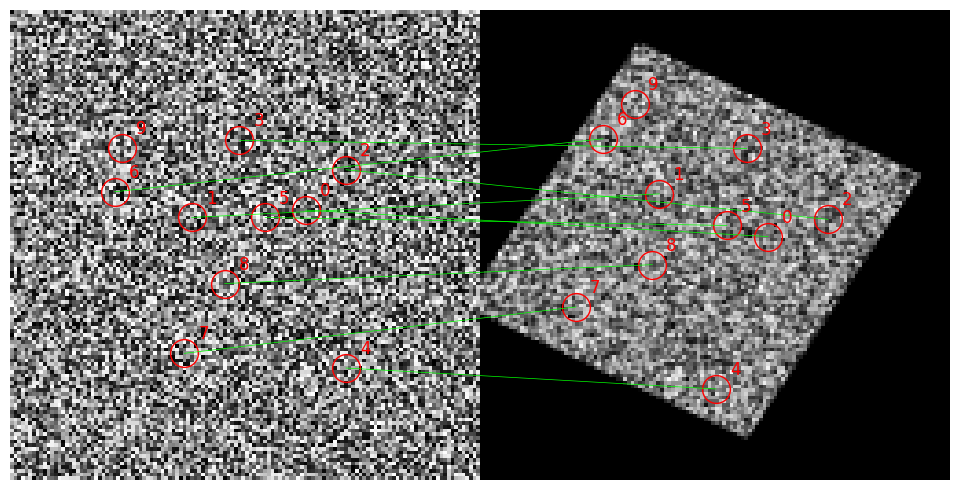

In [49]:
# Verificar as dimensões dos dados transformados
print("Dimensões dos dados transformados:")
print("Dados de entrada:", out.shape)
print("Dados de pontos-chave:", transform.shape)

matches =[(i,i) for i in range(9)]
plot_matches_keypoints(X1[0,0], batch_points[0], out[0,0]*mask_trans[0,0], transform[0],matches)

In [50]:
import torch
import kornia.augmentation as K

transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10, p=0.8),
    data_keys=['input']  # Especificando as chaves de dados
)

# Supondo que você tenha uma imagem chamada "image" que deseja transformar
image = torch.randn(1, 3, 256, 256)  # Exemplo de imagem

# Aplicar a sequência de aumentos à imagem
transformed_image = transformations(image)

# Obter a matriz de transformação resultante
transformation_matrix = transformations.get_transformation_matrix(transformed_image)
print(transformation_matrix)


NotImplementedError: requires params to be provided.